# The development in productivity and hourly wages in Denmark across industries and years.

## Introduction

We consider the 2 following equations:  



given by

\\[
\begin{eqnarray*}
Productivity_{ij} = \frac{Gross\:value\:added_{ij}}{Hours\:worked_{ij}}
\\
\\
Hourly\: wage_{ij} = \frac{Compensation\:of\:employees_{ij}}{Hours\:worked\:by\:employees_{ij}}
\end{eqnarray*}
\\]
where {i} denotes years and {j} denotes industries

**Imports:** We first import all the modules, we need for this notebook.

In [1]:
#Importer vigtige pakker
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import pandas_datareader as pdr
import pandas_datareader.data as web

import datetime
import pydst
dst = pydst.Dst(lang='en')

## Reading in data
From statistics Denmark we load data about the Gross value added and the compensation of employees as well as the hours worked in total in the industries as well as just the hours worked by the employees. 


In [41]:
# a. gettign an orientation in data
dst.get_variables('NABP10') # command to se 'id'
dst.get_variables('NABP10').iloc[0]['values'] # command to se 'values' in 'TRANSAKT'

# b.  loading data 
gva10 = dst.get_data(table_id = 'NABP10', variables={'TRANSAKT':['B1GD','D1D'],'BRANCHE':['*'], 'PRISENHED':['V'], 'TID':['*']})
emp10 = dst.get_data(table_id = 'NABB10', variables={'SOCIO':['EMPH_DC','SALH_DC'],'BRANCHE':['*'], 'TID':['*']})
    
# c. Checking the dimensions  
print(f'Industries in gva10 = {len(gva10.BRANCHE.unique())}')
print(f'Industries in emp10  = {len(emp10.BRANCHE.unique())}')

print(f'Years in gva10 = {len(gva10.TID.unique())}')
print(f'Years in emp10  = {len(emp10.TID.unique())}')

Industries in gva10 = 15
Industries in emp10  = 15
Years in gva10 = 53
Years in emp10  = 53


From table "NABP10" we do only read in data in nominal prices, which is due to the fact that "Compensation of employees" is not given in chain prices.

In [32]:
# b. define dictionaries to rename variables
columns_dict = {}
columns_dict['TRANSAKT'] = 'variable'
columns_dict['BRANCHE'] = 'industry'
columns_dict['PRISENHED'] = 'unit'
columns_dict['TID'] = 'year'
columns_dict['INDHOLD'] = 'value'
columns_dict['SOCIO'] = 'employment'

var_dict = {} # var is for variable
var_dict['B.1g Gross value added'] = 'GVA'
var_dict['D.1 Compensation of employees'] = 'ComEmp'
var_dict['Hours worked (1,000 hours)'] = 'Hours_TOT'
var_dict['Hours worked for employees (1,000 hours)'] = 'Hours_Emp'

unit_dict = {}
unit_dict['2010-prices, chained values'] = 'real'
unit_dict['Current prices'] = 'nominal'

# b. i
gva10.rename(columns=columns_dict,inplace=True)
emp10.rename(columns=columns_dict,inplace=True)

for key,value in var_dict.items():
    gva10.variable.replace(key,value, inplace=True)
    emp10.employment.replace(key,value, inplace=True)

for key,value in unit_dict.items():
    gva10.unit.replace(key,value, inplace=True)

# b. ii redefine value from 'str' to 'float'
emp10.value = emp10.value.astype('float')
gva10['value'] = gva10['value'].apply(pd.to_numeric, errors='coerce')


In [4]:
# Split dataframe emp10 in two - hours total and hours for employees.
H_TOT = emp10.loc[emp10.employment == ('Hours_TOT')]
H_TOT.rename(columns = {'value':'H_TOT'}, inplace=True)

H_Emp = emp10.loc[emp10.employment == ('Hours_Emp')]
H_Emp.rename(columns = {'value':'H_EMP'}, inplace=True)

# Split dataframe gva10 in two - GVA and compensation for employees 
GVA = gva10.loc[gva10.variable == ('GVA')]
GVA.rename(columns = {'value':'GVA'}, inplace=True)

ComEmp = gva10.loc[gva10.variable == ('ComEmp')]
ComEmp.rename(columns = {'value':'ComEmp'}, inplace=True)
GVA.head()

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,variable,industry,unit,year,GVA
0,GVA,Total,nominal,1982,438077
1,GVA,"A Agriculture, forestry and fishing",nominal,1982,23420
2,GVA,B Mining and quarrying,nominal,1982,3871
3,GVA,C Manufacturing,nominal,1982,76773
4,GVA,D_E Utility services,nominal,1982,9757


In [5]:
# dropper 'employment' and 'variable'
H_TOT.drop(columns=['employment'], inplace = True)
H_Emp.drop(columns=['employment'], inplace = True)
GVA.drop(columns=['variable'], inplace = True)
ComEmp.drop(columns=['variable'], inplace = True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [6]:
# c. merged data
merged = pd.merge(GVA,ComEmp,how='left',on=['year','industry'])
merged1 = pd.merge(merged,H_TOT,how='left',on=['year','industry'])
df = pd.merge(merged1,H_Emp,how='left',on=['year','industry'])
df.drop(columns=['unit_y'], inplace = True)

df.GVA = df.GVA.astype('float')
df.ComEmp = df.ComEmp.astype('float')
df

df['Productivity'] = df.GVA / df.H_TOT*1000
df['Hour_wage'] = df.ComEmp / df.H_EMP*1000

#groupby year and industry

df
#df.groupby(['industry','year'])

,industry,unit_x,year,GVA,ComEmp,H_TOT,H_EMP,Productivity,Hour_wage
0,Total,nominal,1982,438077.0,263929.0,3861797.0,3284732.0,113.438640,80.350239
1,"A Agriculture, forestry and fishing",nominal,1982,23420.0,3807.0,333573.0,101920.0,70.209519,37.352826
2,B Mining and quarrying,nominal,1982,3871.0,900.0,9130.0,8663.0,423.986857,103.890107
3,C Manufacturing,nominal,1982,76773.0,50788.0,688864.0,651143.0,111.448704,77.998228
4,D_E Utility services,nominal,1982,9757.0,2774.0,29954.0,29453.0,325.732790,94.183954
5,F Construction,nominal,1982,21434.0,16920.0,283505.0,231764.0,75.603605,73.005298
6,G_I Trade and transport etc.,nominal,1982,88013.0,52817.0,871147.0,714063.0,101.031169,73.966863
7,J Information and communication,nominal,1982,11297.0,7506.0,91209.0,85760.0,123.858391,87.523321
8,K Financial and insurance,nominal,1982,20791.0,9648.0,109129.0,109129.0,190.517644,88.409130
9,LA Real estate activities and renting of non-r...,nominal,1982,6909.0,652.0,11570.0,8755.0,597.147796,74.471730


In [26]:
# laver kopi af datasæt
df_index = df.copy()
df_index.sort_values(['industry','year'], inplace=True)

# Normalizing by 2010 
df_index['P: indexed=2010'] = df_index.groupby(['industry'])['Productivity'].transform(lambda x: x/x.iloc[44]*100)
df_index['H: indexed=2010'] = df_index.groupby(['industry'])['Hour_wage'].transform(lambda x: x/x.iloc[44]*100)

#merged_alt['P: indexed=2010'] = merged_alt.groupby(['industry','year'])['Productivity'].transform(lambda x: x/x)
#df_index['H: indexed=2010'] =
df_index.tail(10)


,industry,unit_x,year,GVA,ComEmp,H_TOT,H_EMP,Productivity,Hour_wage,P: indexed=2010,H: indexed=2010
120,Total,nominal,2009,1484941.0,945677.0,4044695.0,3712721.0,367.132998,254.712649,93.153670,97.290677
150,Total,nominal,2010,1562743.0,953668.0,3965191.0,3642654.0,394.115441,261.805815,100.000000,100.000000
165,Total,nominal,2011,1593742.0,966474.0,4004332.0,3677588.0,398.004461,262.801053,100.986772,100.380144
210,Total,nominal,2012,1636086.0,977516.0,3938133.0,3622095.0,415.447117,269.875859,105.412545,103.082454
390,Total,nominal,2013,1669456.0,993804.0,3943877.0,3628374.0,423.303262,273.897895,107.405907,104.618721
405,Total,nominal,2014,1718979.0,1017743.0,3945246.0,3631759.0,435.708952,280.234179,110.553636,107.038943
255,Total,nominal,2015,1767126.0,1049061.0,3980822.0,3650462.0,443.909826,287.377598,112.634467,109.767462
330,Total,nominal,2016,1821807.0,1083176.0,4055490.0,3742959.0,449.219946,289.390293,113.981818,110.536236
345,Total,nominal,2017,1892931.0,1120750.0,4100576.0,3793296.0,461.625635,295.455456,117.129548,112.852901
780,Total,nominal,2018,1922983.0,1164748.0,4135914.0,3828657.0,464.947530,304.218424,117.972422,116.200026


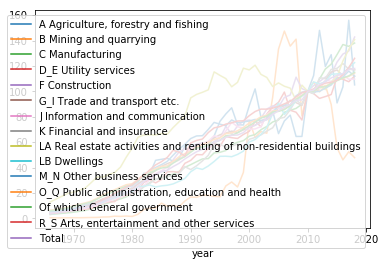

In [30]:
# Forsøg på at lave plot
#df_index.groupby(['industry','year'])['Productivity'].plot(legend=True)
#plt.show()

# d. plot
def plot(df):
    df_indexed = df_index.set_index('year')
    #I = df_indexed.unit == 'real'
    #df_indexed[I].groupby(['variable'])['indexed'].plot(legend=True);
    df_indexed.groupby(['industry'])['P: indexed=2010'].plot(legend=True);
    
plot(df_index)

In [ ]:
# skaber nye kolloner - forsøger at erstatte denne kode
emp10['Hours_TOT'] = emp10.value[emp10.employment == 'Hours_TOT']
emp10['Hours_Emp'] = emp10.value[emp10.employment == 'Hours_Emp']
gva10['GVA'] = gva10.value[gva10.variable == 'GVA']
gva10['ComEmp'] = gva10.value[gva10.variable == 'ComEmp']

gva10.tail()

In [84]:
# dropper 'employment'
emp10.drop(columns=['employment'], inplace = True)
emp10.drop(columns=['value'], inplace = True)
gva10.drop(columns=['variable'], inplace = True)
gva10.drop(columns=['value'], inplace = True)

In [94]:
 
#emp10 = emp10.dropna()
#gva10.head()
emp10.tail()
gva10.tail()

,industry,unit,year,GVA,ComEmp


In [86]:
# c. merged data
merged = pd.merge(gva10,emp10,how='left',on=['year','industry'])
merged

,industry,unit,year,GVA,ComEmp,Hours_TOT,Hours_Emp
0,Total,nominal,1966,73555.0,NaN,4604383.0,NaN
1,Total,nominal,1966,73555.0,NaN,NaN,3637974.0
2,Total,nominal,1967,80538.0,NaN,4537166.0,NaN
3,Total,nominal,1967,80538.0,NaN,NaN,3605118.0
4,Total,nominal,1968,88782.0,NaN,4467413.0,NaN
5,Total,nominal,1968,88782.0,NaN,NaN,3568827.0
6,Total,nominal,1969,101289.0,NaN,4453350.0,NaN
7,Total,nominal,1969,101289.0,NaN,NaN,3585142.0
8,Total,nominal,1970,112399.0,NaN,4449231.0,NaN
9,Total,nominal,1970,112399.0,NaN,NaN,3608565.0
